In [1]:
from TradingEnvironment import StockTrading as Env
import DDPG_Algo as ddpg
import pandas as pd
import numpy as np

In [2]:
window=5
frame_bound=(6,300)

In [3]:
df = pd.read_csv('data/NIFTY50.csv')
my_env = Env(df,5,(6,120))

Total Return: -4.89 % 			Total Reward: -62.0188547032121


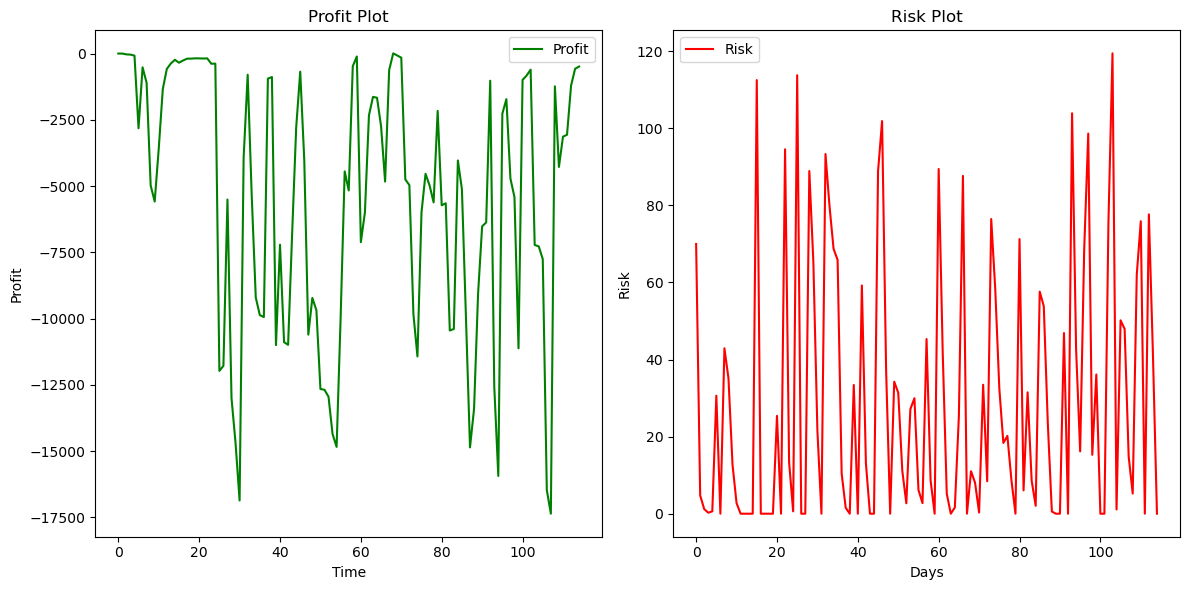

In [4]:
obs,_=my_env.reset(10000,0,0)
done=0
total_reward=0
while not done:
    action=my_env.random_action()
    obs,reward,done,info=my_env.step(action)
    total_reward+=reward
    if done:
        print(f"Total Return: {my_env.percentageReturn()} %",f"\t\t\tTotal Reward: {total_reward}")
        my_env.render()

In [5]:
# Initialize environment and agent
env = Env(df, window, frame_bound)
state_dim = 10  # This is the size of your flattened state
action_dim = 2  # This is the size of your action space

actor = ddpg.Actor(state_dim, action_dim)
critic = ddpg.Critic(state_dim , action_dim)
agent = ddpg.DDPGAgent(env, actor, critic, actor_lr=9`1264ty7u8-0pe-4, critic_lr=1e-3, gamma=0.99, tau=1e-2, buffer_maxlen=100000)

# Parameters
num_episodes = 100  # How many episodes of interaction to generate
max_steps = 1000  # How many steps of interaction (max) to generate for each episode
batch_size = 100  # How many experiences to use for each update of the networks
max_reward = None
# Start training loop
for i_episode in range(1, num_episodes+1):
    state,_ = env.reset(100000, 0, 0)
    episode_reward = 0

    for t in range(max_steps):
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)

        agent.replay_buffer.push(state, action, reward, next_state, done)
        if len(agent.replay_buffer) > batch_size:
            agent.update(batch_size)

        state = next_state
        episode_reward += reward

        if done or t == max_steps-1:
            print("Episode %d, reward %f" % (i_episode, episode_reward))
            break
    agent.noise.reset()
    if max_reward is None or episode_reward > max_reward:
        print("Episode: {}, Reward: {}, New record!".format(i_episode, episode_reward))
        max_reward = episode_reward
        agent.save("best_model")


/home/vkali/PycharmProjects/FinSearch-Project-2023/envionment_2_built_from_scratch/DDPG_Algo.py:148: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  actions = torch.FloatTensor(actions)


Episode 1, reward -586.955978
Episode: 1, Reward: -586.9559781877757, New record!
Episode 2, reward -586.959240
Episode 3, reward -586.958437
Episode 4, reward -586.957911
Episode 5, reward -586.959223
Episode 6, reward -586.959240
Episode 7, reward -586.957726
Episode 8, reward -586.959240
Episode 9, reward -586.958620
Episode 10, reward -586.958869
Episode 11, reward -586.958105
Episode 12, reward -586.959240
Episode 13, reward -586.959240
Episode 14, reward -586.957604
Episode 15, reward -586.957556
Episode 16, reward -586.956964
Episode 17, reward -586.956589
Episode 18, reward -586.958988
Episode 19, reward -586.959240
Episode 20, reward -586.958948
Episode 21, reward -586.959240
Episode 22, reward -586.954867
Episode: 22, Reward: -586.9548665347702, New record!
Episode 23, reward -586.959240
Episode 24, reward -586.959240
Episode 25, reward -586.953623
Episode: 25, Reward: -586.9536228887501, New record!
Episode 26, reward -586.958150
Episode 27, reward -586.959240
Episode 28, re

In [6]:
frame_bound=(6,500)

env = Env(df, window, frame_bound)

# Create a DDPG agent
agent = ddpg.DDPGAgent(env, actor, critic, actor_lr=1e-4, critic_lr=1e-3, gamma=0.99, tau=1e-2, buffer_maxlen=100000,sigma=0)

# Load the models
agent.load("best_model")  # replace "model" with your actual filename prefix


In [7]:
# Reset the environment to get the initial state
state, info = env.reset(cash=10000, long=0, short=0)  # replace these parameters with your own initial conditions

done = False
while not done:
    # Reshape state to 2D array
    state = state.reshape(1,-1)

    # Get an action from the DDPG agent (we don't need the epsilon for the exploration when using the model for prediction)
    action = agent.get_action(state)

    # Take a step in the environment with the action
    next_state, reward, done, info = env.step(action)

    # Set the current state to the next state
    state = next_state
    if done:
        print(f"The current net value: {env.curr_net_val}")



The current net value: -13979.42190050621
